In [1]:
import sys

import matplotlib.pyplot as plt
import pandas as pd
import pydiffvg

In [2]:
# %load_ext autoreload
# %autoreload 2
import covergan


In [3]:
labels = {'neutral': 0, 'happy': 1, 'sad': 2, 'surprise': 3, 'fear': 4, 'disgust': 5, 'anger': 6, 'contempt': 7}

In [4]:
import importlib, sys
importlib.reload(covergan)

<module 'covergan' from '/home/dmitriy/OVE/covergan/__init__.py'>

In [5]:
import pandas as pd
# data = pd.read_csv('/home/dmitriy/OVE/official_data/artemis_dataset_release_v0.csv')

In [6]:
# val_key = dict(zip(data.emotion.unique(), data.index))
# key_val = {v:k for k,v in val_key.items()}
# key_val

In [7]:
# ndata = data[data['art_style']=='Color_Field_Painting'].groupby(['painting', 'art_style'])['emotion'].apply(lambda x: ','.join(x)).reset_index()

In [8]:
# ndata

In [9]:
# ndata = ndata.drop([197,198,199]).reset_index()

In [10]:
# %load_ext autoreload
# %autoreload 2
import covergan

In [11]:
# ndata.index

In [12]:
import os

# Get the list of all files and directories
path = "/home/dmitriy/OVE/data"
dir_list = os.listdir(path)
dir_list

['sad', 'fear', 'surprise', 'smiling', 'anger', 'contempt', 'disgust']

In [13]:
label= {'smiling': 0, 'sad': 1, 'surprise': 2, 'fear': 3, 'disgust': 4, 'anger': 5, 'contempt': 6}

In [14]:
key_val = {v:k for k,v in label.items()}
key_val

{0: 'smiling',
 1: 'sad',
 2: 'surprise',
 3: 'fear',
 4: 'disgust',
 5: 'anger',
 6: 'contempt'}

In [15]:
# inputs = []
# labels = []
# for d1 in dir_list:
#     dir_new = os.path.join(path,d1)
#     images = os.listdir(dir_new)
#     for image in images:
#         inputs.append(image)
#         labels.append(label[d1])



In [16]:
# data = pd.DataFrame({"image":inputs,"label":labels})
# data.to_csv('out.csv')

In [17]:
# data[data['image'].isin(data[data.duplicated('image')]['image'])]

In [18]:
from colorer.music_palette_dataset import PaletteDatasetSmiles,ImageDatasetSmiles
dataset = PaletteDatasetSmiles(8,156,'name','/home/dmitriy/OVE/covergan/weights','/home/dmitriy/OVE/data1',pandas_dir='/home/dmitriy/OVE/out.csv')
dataset_image = ImageDatasetSmiles(8,156,'name','/home/dmitriy/OVE/covergan/weights','/home/dmitriy/OVE/data1',pandas_dir='/home/dmitriy/OVE/out.csv')

In [19]:
dataset_image[0][1].shape

torch.Size([128, 128, 3])

In [20]:
# from colorer.music_palette_dataset import PaletteDataset,ImageDataset
# dataset = PaletteDataset(8,1599,'name','/home/dmitriy/OVE/covergan/weights','/home/dmitriy/OVE/wikiart',pandas_dir='/home/dmitriy/OVE/official_data/artemis_dataset_release_v0.csv')
# dataset_image = ImageDataset(8,1599,'name','/home/dmitriy/OVE/covergan/weights','/home/dmitriy/OVE/wikiart',pandas_dir='/home/dmitriy/OVE/official_data/artemis_dataset_release_v0.csv')

In [21]:
# dataset.data = ndata
# dataset_image.data = ndata

In [22]:
# for i in range(len(dataset_image)):
#     print(dataset_image[i][1].shape)
#     print(i)

In [23]:
import torch

In [24]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [25]:
from colorer.models.colorer_dropout import Colorer2
z_dim=32
num_gen_layers=3
colors_count = 8
colorer = Colorer2(
        z_dim=z_dim,
        audio_embedding_dim=7,
        num_layers=num_gen_layers,
        colors_count=colors_count)

In [26]:
colorer

Colorer2(
  (model_): Sequential(
    (0): Linear(in_features=39, out_features=29, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): BatchNorm1d(29, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=29, out_features=19, bias=True)
    (5): Dropout(p=0.2, inplace=False)
    (6): BatchNorm1d(19, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Linear(in_features=19, out_features=24, bias=True)
    (9): Sigmoid()
  )
)

In [27]:
from colorer.models.gan_colorer import ColorerDiscriminator

In [28]:
disc = ColorerDiscriminator(audio_embedding_dim=7, num_layers=3,colors_count= colors_count).to(device)

In [29]:
disc

ColorerDiscriminator(
  (adv_layer): Sequential(
    (0): Linear(in_features=31, out_features=21, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=21, out_features=11, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=11, out_features=8, bias=True)
    (7): Sigmoid()
  )
)

In [30]:
def weighted_mse_loss(input, target, weight=None):
    if weight is None:
        max_weight = input.size()[1]
        weight = torch.tensor([(max_weight - i // 3) // 3 for i in range(max_weight)]).to(input.device)
        weight = weight.repeat((len(input), 1))
    return (weight * (input - target) ** 2).mean()

In [31]:
def get_noise(n_samples, input_dim, device):
    """
    Function for creating noise vectors: Given the dimensions (n_samples, input_dim)
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        input_dim: the dimension of the input vector, a scalar
        device: the device type
    """
    return torch.randn(n_samples, input_dim, device=device)

In [32]:
from torch.utils.data.dataloader import DataLoader
batch_size=16
train_dataloader = DataLoader(dataset,drop_last=True, batch_size=batch_size, shuffle=True)

In [33]:
def get_checkpoint_filename(checkpoint_root: str, checkpoint_name: str, epoch: int = None) -> str:
    suffix = f"-{epoch}" if epoch is not None else ""
    return f"{checkpoint_root}/{checkpoint_name}{suffix}.pt"

In [34]:
from captioner_train import logger
import os


def load_checkpoint(checkpoint_root: str, checkpoint_name: str,
                    models) -> int:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    filename = get_checkpoint_filename(checkpoint_root, checkpoint_name)

    if os.path.isfile(filename):
        logger.info(f"Found {filename}, loading")
        checkpoint = torch.load(filename, map_location=device)
        for i, model in enumerate(models):
            model.load_state_dict(checkpoint[f"{i}_state_dict"])
            print('Loaded')
        epochs_done = checkpoint[f"epochs_done"]
        logger.info(f"{filename} loaded")
        return epochs_done
    else:
        return 0

In [35]:
def save_checkpoint(checkpoint_root: str, checkpoint_name: str, epochs_done: int, backup_epochs: int,
                    models):
    checkpoint_dict = {}
    for i, model in enumerate(models):
        checkpoint_dict[f"{i}_state_dict"] = model.state_dict()
    checkpoint_dict[f"epochs_done"] = epochs_done

    if not backup_epochs:
        # Unconditional save
        filename = get_checkpoint_filename(checkpoint_root, checkpoint_name)
        torch.save(checkpoint_dict, filename)
        logger.info(f"{filename} saved")
    if backup_epochs and epochs_done and epochs_done % backup_epochs == 0:
        # Regular backup
        filename = get_checkpoint_filename(checkpoint_root, checkpoint_name, epochs_done)
        torch.save(checkpoint_dict, filename)
        logger.info(f"Backup {filename} saved")

In [36]:
disc

ColorerDiscriminator(
  (adv_layer): Sequential(
    (0): Linear(in_features=31, out_features=21, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=21, out_features=11, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=11, out_features=8, bias=True)
    (7): Sigmoid()
  )
)

In [37]:
from tqdm.notebook import tqdm
import logging
import torch
from torch.utils.data.dataloader import DataLoader
n_epochs = 2500 # training_params["n_epochs"]
lr1 = 2e-4
lr2 = 2e-4
checkpoint_root ='/home/dmitriy/OVE/covergan/weights'
backup_epochs = 500
gen_opt = torch.optim.Adam(colorer.parameters(), lr=lr1)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr2)
criterion = torch.nn.BCELoss()

# model_name = f'colorer_{colorer.color_type}_{colorer.colors_count}_colors'
model_name = f'smile_colorer_{colorer.colors_count}_colors_{train_dataloader.dataset.sorted_color}'
print("Trying to load checkpoint.")
epochs_done = load_checkpoint(checkpoint_root, model_name, [colorer, gen_opt])

if epochs_done:
    logger.info(f"Loaded a checkpoint with {epochs_done} epochs done")
steps = 8
step = 0
log_interval = 100
# for epoch in range(epochs_done + 1, n_epochs + epochs_done + 1):
#     colorer.train()
#     running_D_test_loss = 0.0
#     running_G_test_loss = 0.0
#     count = 0
#     for X_batch, y_batch in train_dataloader:
#         torch.cuda.empty_cache()
#         y_batch = y_batch.to(device)
#
#         cur_batch_size = len(X_batch)
#         X_batch = X_batch.float().to(device)
#         X_batch_disc = X_batch
#
#         real_outputs = disc(X_batch_disc, y_batch)
#         real_label = torch.ones(y_batch.shape[0], colors_count).to(device)
#         z = get_noise(cur_batch_size, z_dim, device=device)
#
#         fake_inputs = colorer(z, X_batch_disc)
#         fake_outputs = disc(X_batch_disc, fake_inputs)
#
#         fake_label = torch.zeros(fake_inputs.shape[0], colors_count).to(device)
#         outputs = torch.cat((real_outputs, fake_outputs), dim=0)
#         targets = torch.cat((real_label, fake_label), dim=0)
#         D_loss = criterion(outputs, targets)
#         running_D_test_loss += D_loss.item()
#         disc_opt.zero_grad()
#         D_loss.backward()
#         step+=1
#         if step%steps==0:
#             step = 0
#             disc_opt.step()
#             gen_opt.zero_grad()
#             z = get_noise(cur_batch_size, z_dim, device=device)
#
#             fake_inputs = colorer(z, X_batch_disc)
#             fake_outputs = disc(X_batch_disc, fake_inputs)
#             fake_targets = torch.ones(fake_inputs.shape[0], colors_count).to(device)
#             G_loss = criterion(fake_outputs, fake_targets)
#             gen_opt.zero_grad()
#             G_loss.backward()
#             gen_opt.step()
#             running_G_test_loss += G_loss.item()
#         # if (count + 1) % log_interval == 0:
#         #         print('Epoch {} Iteration {}: discriminator_loss {:.3f} generator_loss {:.3f}'
#         #               .format(epoch, count, D_loss.item(), G_loss.item()))
#         save_checkpoint(checkpoint_root, model_name, epoch, backup_epochs, [colorer, disc, gen_opt, disc_opt])
#         count+=1
#     if (epoch + 1) % log_interval == 0:
#         avg_G_test_loss = running_G_test_loss / (count + 1)
#         avg_D_test_loss = running_D_test_loss / (count+ 1)
#         print('Train LOSS: colorer {}, disc {}'.format(avg_G_test_loss, avg_D_test_loss))

Trying to load checkpoint.


In [38]:
colorer.load_state_dict(torch.load('/home/dmitriy/OVE/covergan/weights/smile_colorer_8_colors_sorted-1000.pt')['0_state_dict'])

<All keys matched successfully>

In [39]:
from outer.models.discriminator import Discriminator
from outer.models.my_gen_fixed_6figs32_good import MyGeneratorFixedSixFigs32Good

generator_type = MyGeneratorFixedSixFigs32Good
discriminator_type = Discriminator

In [40]:
num_gen_layers = 4
num_disc_conv_layers = 3
num_disc_linear_layers = 2
z_dim = 32 # Dimension of the noise vector
# z_dim = 512  # Dimension of the noise vector

# Painter properties
path_count = 3
path_segment_count = 4
max_stroke_width = 0.01  # relative to the canvas size

In [41]:
gen = MyGeneratorFixedSixFigs32Good(z_dim,7,num_gen_layers,128,max_stroke_width)
gen

MyGeneratorFixedSixFigs32Good(
  (emb): Embedding(7, 7)
  (model_): Sequential(
    (0): Linear(in_features=39, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=1024, out_features=805, bias=True)
    (7): Tanh()
  )
)

In [42]:
disc = Discriminator(128,7,3,2)
disc

Discriminator(
  (emb): Embedding(7, 7)
  (model): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.5, inplace=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): AdaptiveAvgPool2d(output_size=1)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=64, out_features=32, bias=True)
    (8): Sigmoid()
  )
  (adv_layer): Sequential(
    (0): Linear(in_features=39, out_features=1, bias=True)
    (1): Sigmoid()
  )
)

In [43]:
import matplotlib.pyplot as plt
dataset_image[6][0]

tensor([0., 1., 0., 0., 0., 0., 0.])

In [44]:
def plot_losses(epoch: int, cur_step: int, display_steps: int, bin_steps: int, losses: [(str, [float])]):
    if cur_step % display_steps == 0 and cur_step > 0:
        loss_stats = []

        for loss_name, loss_values in losses:
            loss_mean = sum(loss_values[-display_steps:]) / display_steps
            if "loss" not in loss_name.lower() and "metric" not in loss_name.lower():
                loss_name += " Loss"
            loss_stats.append(f"{loss_name}: {loss_mean}")

            num_examples = (len(loss_values) // bin_steps) * bin_steps
            plt.plot(
                range(num_examples // bin_steps),
                torch.Tensor(loss_values[:num_examples]).view(-1, bin_steps).mean(1),
                label=loss_name
            )

        logger.info(f"Epoch {epoch} (step {cur_step}): " + ", ".join(loss_stats))
        plt.legend()
        print("Saving losses to png file")
        import covergan_train
        # plt.savefig(f"{covergan_train.logger.plots_dir}/losses-{epoch}-{cur_step}.png")
        plt.show()
        plt.close()
    elif cur_step == 0:
        logger.info("The training is working")

In [45]:
from matplotlib.lines import Line2D
from torchvision.transforms.functional import to_pil_image
import numpy as np

In [46]:
def get_gradient_penalty(disc, real, fake, audio_embedding):
    # Mix the images together
    epsilon = torch.rand((real.size(0), 1, 1, 1), device=real.device)
    mixed_images = (real * epsilon + fake * (1 - epsilon)).requires_grad_(True)

    # Calculate the critic's scores on the mixed images
    mixed_scores = disc(mixed_images, audio_embedding)

    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=mixed_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(len(gradient), -1)

    # Calculate the magnitude of every row
    gradient_norm = gradient.norm(2, dim=1)

    # Penalize the mean squared distance of the gradient norms from 1
    penalty = ((gradient_norm - 1) ** 2).mean()
    return penalty

In [47]:
def plot_grad_flow(named_parameters, model_name: str, epoch=None, cur_step=None):
    """Plots the gradients flowing through different layers in the network during training.
    Can be used for checking for possible gradient vanishing/exploding problems.

    Usage: Plug this function in Trainer class after loss.backwards() as
    `plot_grad_flow(self.model.named_parameters())` to visualize the gradient flow
    """

    # Calculate the stats
    avg_grads = []
    max_grads = []
    layers = []
    for n, p in named_parameters:
        if p.requires_grad and ("bias" not in n) and p.grad is not None:
            layers.append(n)
            avg_grads.append(p.grad.abs().mean())
            max_grads.append(p.grad.abs().max())

    # Initialize plot canvas
    fig = plt.figure()
    fig.set_size_inches(6, 6)

    # Plot
    plt.bar(np.arange(len(max_grads)), max_grads, alpha=0.2, lw=1, color="c")  # Max gradients
    plt.bar(np.arange(len(max_grads)), avg_grads, alpha=0.2, lw=1, color="b")  # Mean gradients
    plt.hlines(0, 0, len(avg_grads) + 1, lw=2, color="k")  # Zero gradient line
    plt.xticks(range(0, len(avg_grads), 1), layers, rotation="vertical")

    # Set display options
    plt.xlim(left=0, right=len(avg_grads))
    plt.ylim(bottom=-0.001, top=0.02)  # Zoom in on the lower gradient regions
    plt.xlabel('Layers')
    plt.ylabel('average gradient')
    plt.title(f'Gradient flow in {model_name}')
    plt.grid(True)
    plt.legend(
        [
            Line2D([0], [0], color="c", lw=4),
            Line2D([0], [0], color="b", lw=4),
            Line2D([0], [0], color="k", lw=4)
        ],
        [
            'max-gradient',
            'mean-gradient',
            'zero-gradient'
        ]
    )

    fig.tight_layout()
    plt.plot()
    if epoch is not None:
        print("Saving grad flow to png file")
        import covergan_train
        # plt.savefig(f"{covergan_train.logger.plots_dir}/grad-flow-{epoch}-{cur_step}.png")
    plt.show()
    plt.close()


In [48]:
def plot_real_fake_covers(emotions,real_cover_tensor: torch.Tensor, fake_cover_tensor: torch.Tensor,
                          disc_real_pred: torch.Tensor = None, disc_fake_pred: torch.Tensor = None,
                          epoch=None, cur_step=None, plot_saving_dir="./plots"):
    sample_count = 5  # max covers to draw

    real_cover_tensor = real_cover_tensor[:sample_count]
    fake_cover_tensor = fake_cover_tensor[:sample_count]
    emotions = emotions[:sample_count].numpy()

    rows = min(sample_count, len(real_cover_tensor))
    cols = 2
    fig = plt.figure()
    fig.set_size_inches(6 * cols, 6 * rows)
    for i in range(rows):
        real = real_cover_tensor[i]
        fake = fake_cover_tensor[i]
        emotion = emotions[i]
        emo = []
        for j in range(len(emotion)):
            if emotion[j]==1:
                emo.append(key_val[j])
        # real_pil = to_pil_image(real,mode="RGB")
        fake_pil = to_pil_image(fake,mode="RGB")

        real_score = disc_real_pred[i].item() if disc_real_pred is not None else None
        fake_score = disc_fake_pred[i].item() if disc_fake_pred is not None else None

        for (j, (pil, score)) in enumerate([((real/255).permute(1,2,0), real_score), (fake_pil, fake_score)]):
            plt.subplot(rows, cols, i * cols + j + 1)
            plt.imshow(pil)
            if score is not None:
                plt.text(10, 10, f'{emo}', backgroundcolor='w', fontsize=10.0)
            plt.xticks([])
            plt.yticks([])

    fig.tight_layout()
    plt.plot()
    if epoch is not None:
        print("Saving covers to png file")
        import covergan_train
        # print(covergan_train.logger.plots_dir)
        # plt.savefig(f"{covergan_train.logger.plots_dir}/covers-{epoch}-{cur_step}.png")
    plt.show()
    plt.close()

In [49]:
dataloader = DataLoader(dataset_image,drop_last=True, batch_size=batch_size, shuffle=True)

In [50]:
import random


def mismatching_permute(t: torch.Tensor) -> torch.Tensor:
    shift = random.randrange(start=0, stop=len(t))
    return torch.cat((t[shift:], t[:shift]))

PyDiffVG uses GPU: False


Trying to load checkpoint.


  0%|          | 0/19 [00:00<?, ?it/s]The training is working


Saving covers to png file


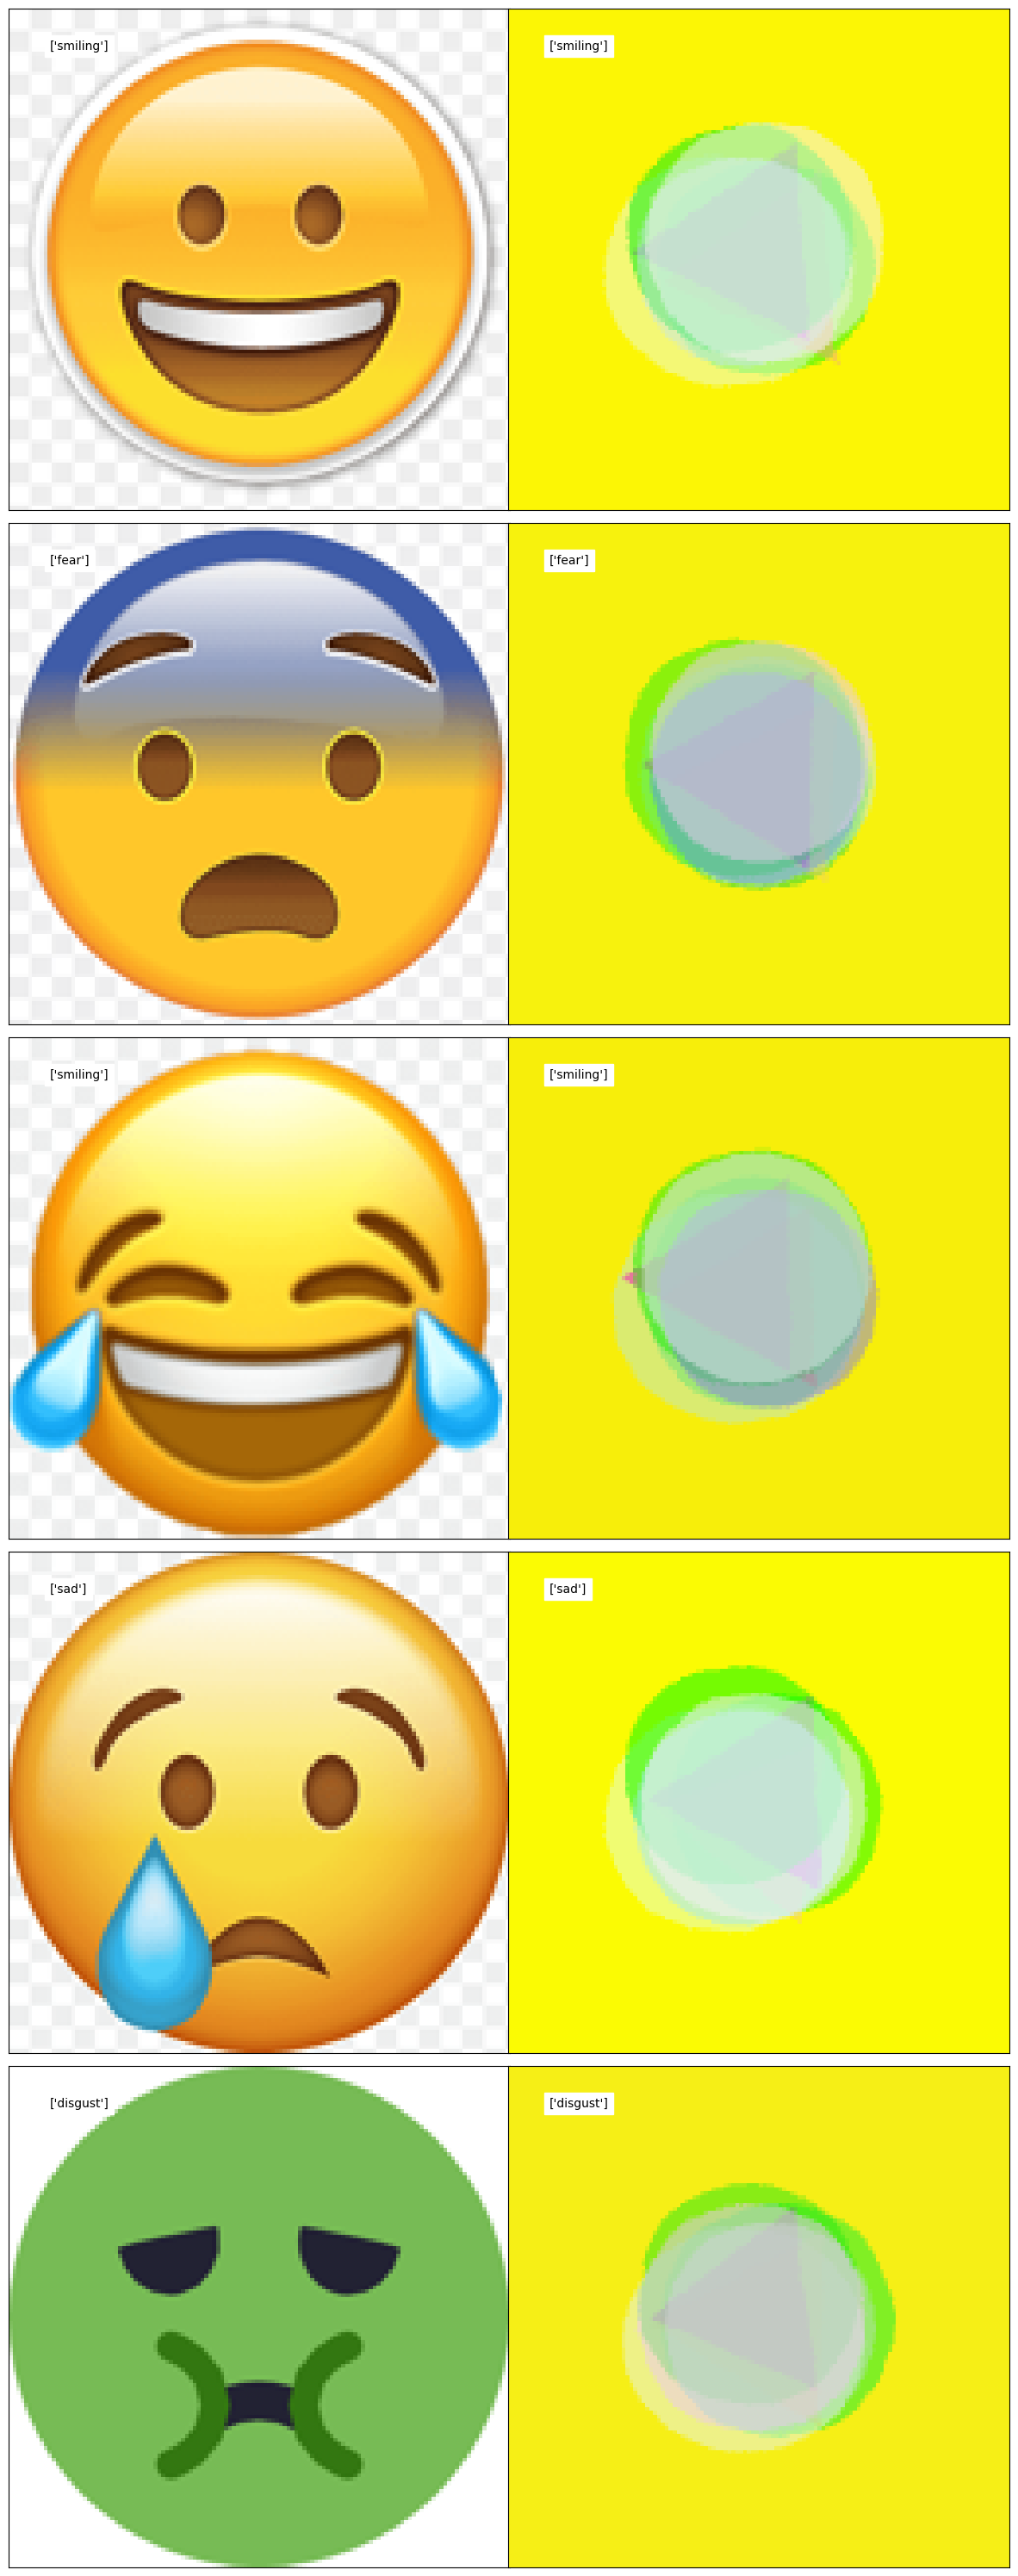

/home/dmitriy/OVE/covergan/weights/cgan_out.pt saved
  5%|▌         | 1/19 [00:01<00:26,  1.48s/it]/home/dmitriy/anaconda3/envs/InnPrac/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 26%|██▋       | 5/19 [00:03<00:08,  1.60it/s]Epoch 1 (step 5): Generator Loss: 0.6665033102035522, Discriminator Adversarial Loss: 0.698163902759552, Discriminator Mismatches Loss: 0.0


Saving losses to png file


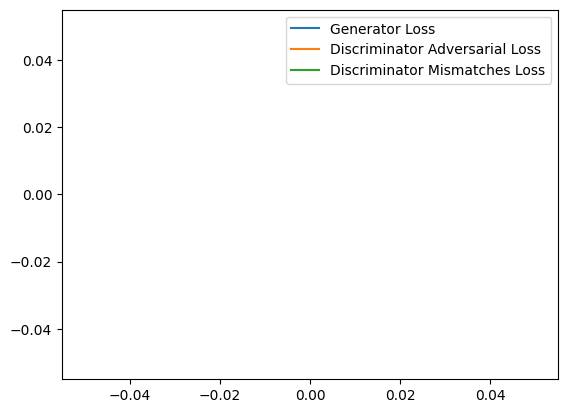

Saving covers to png file


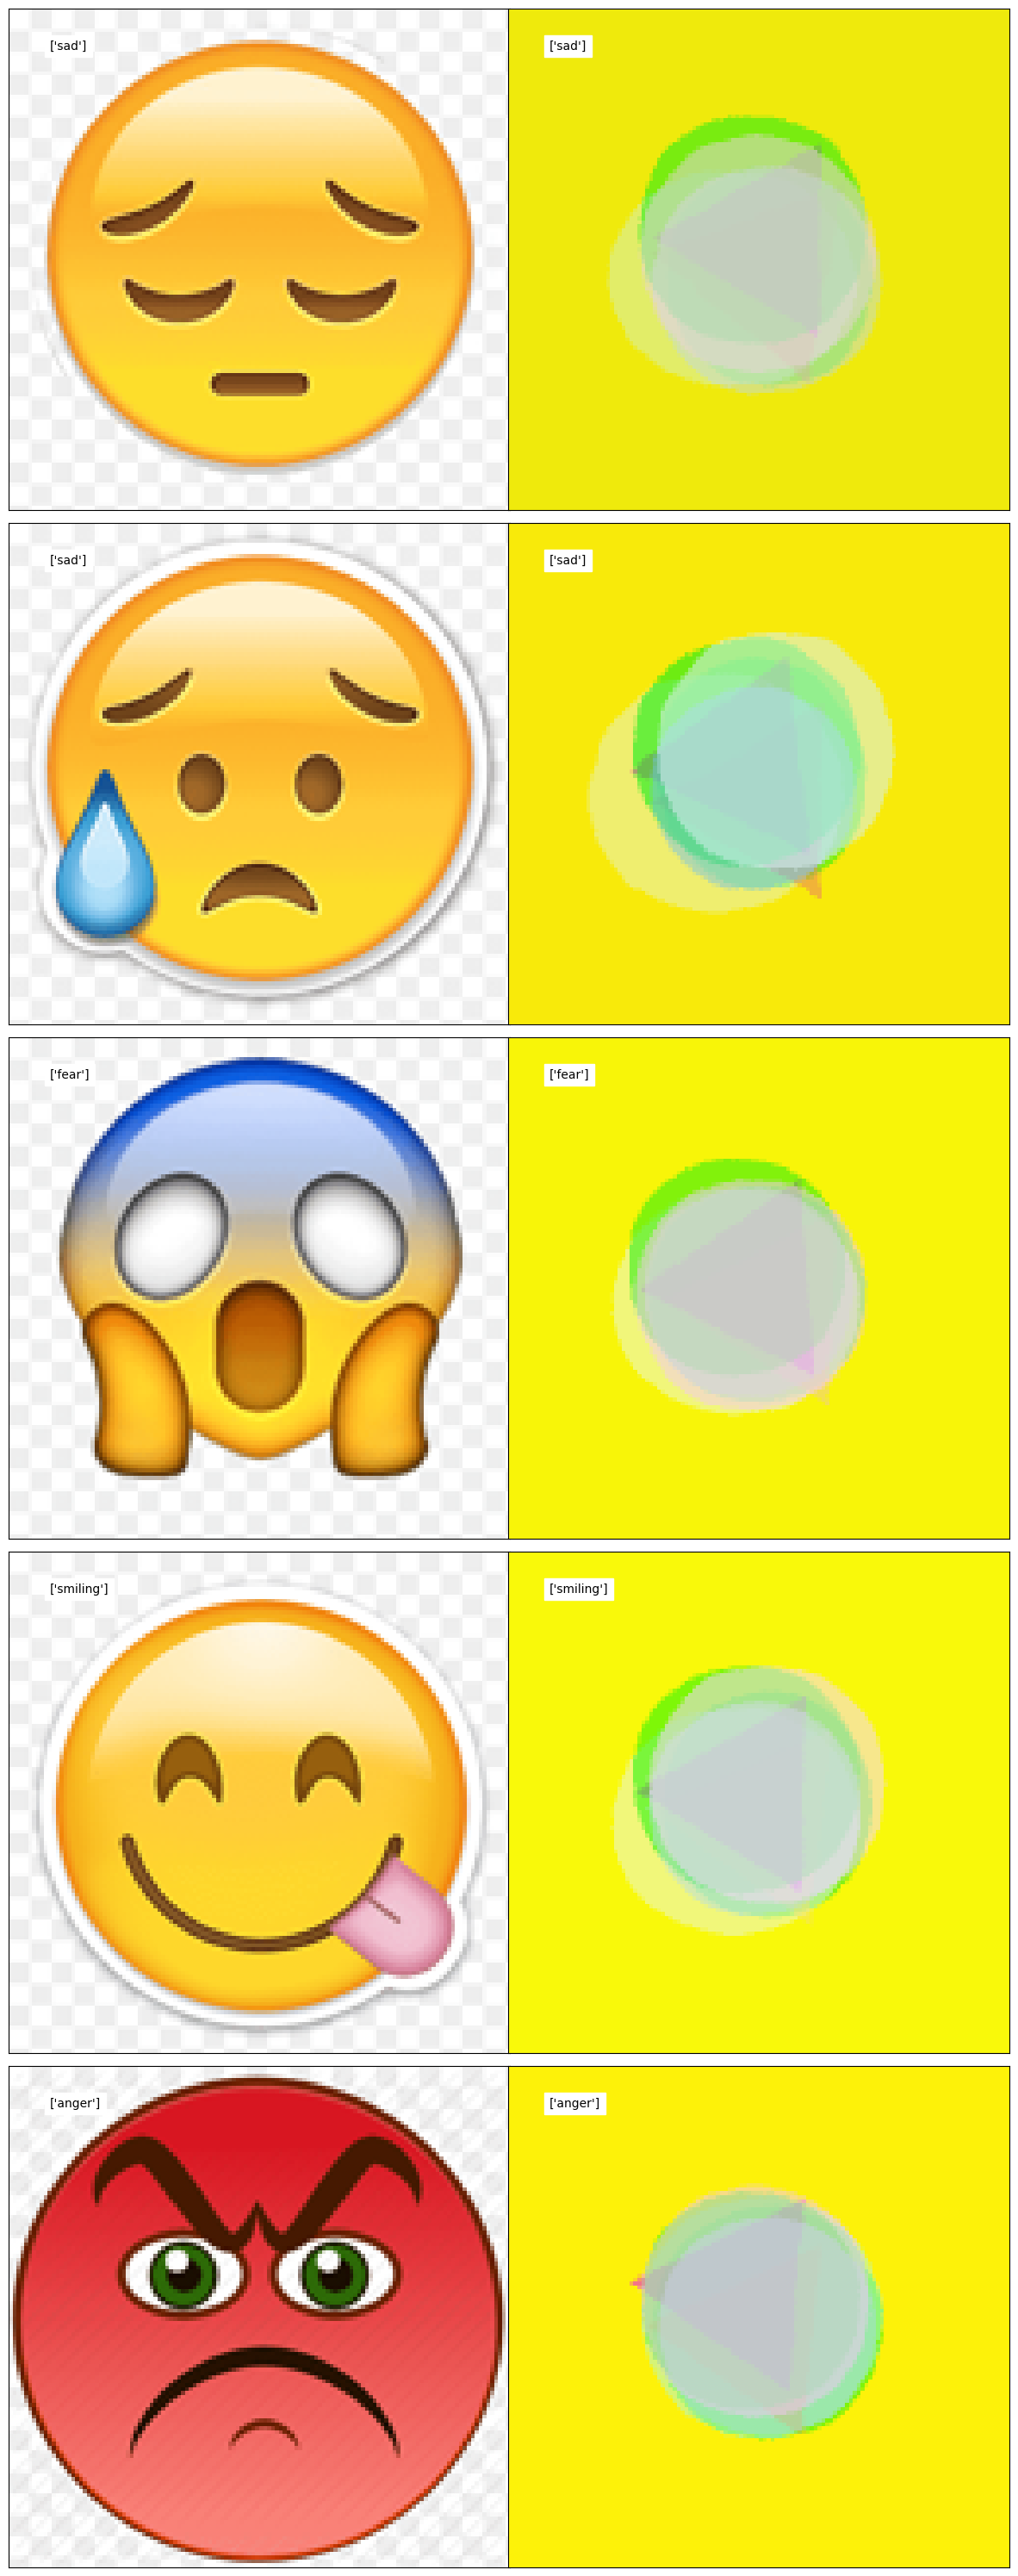

/home/dmitriy/OVE/covergan/weights/cgan_out.pt saved
 53%|█████▎    | 10/19 [00:07<00:05,  1.73it/s]Epoch 1 (step 10): Generator Loss: 0.6381701469421387, Discriminator Adversarial Loss: 0.6992239236831665, Discriminator Mismatches Loss: 0.0


Saving losses to png file


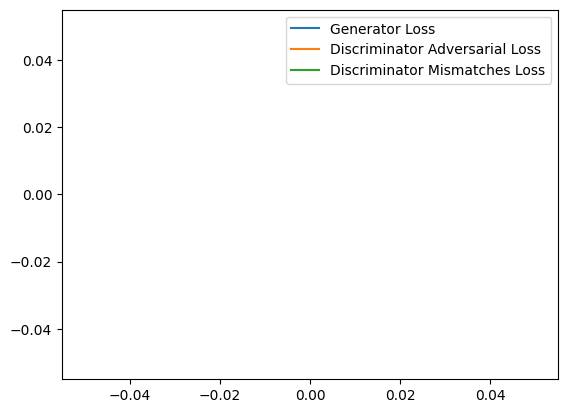

Saving covers to png file


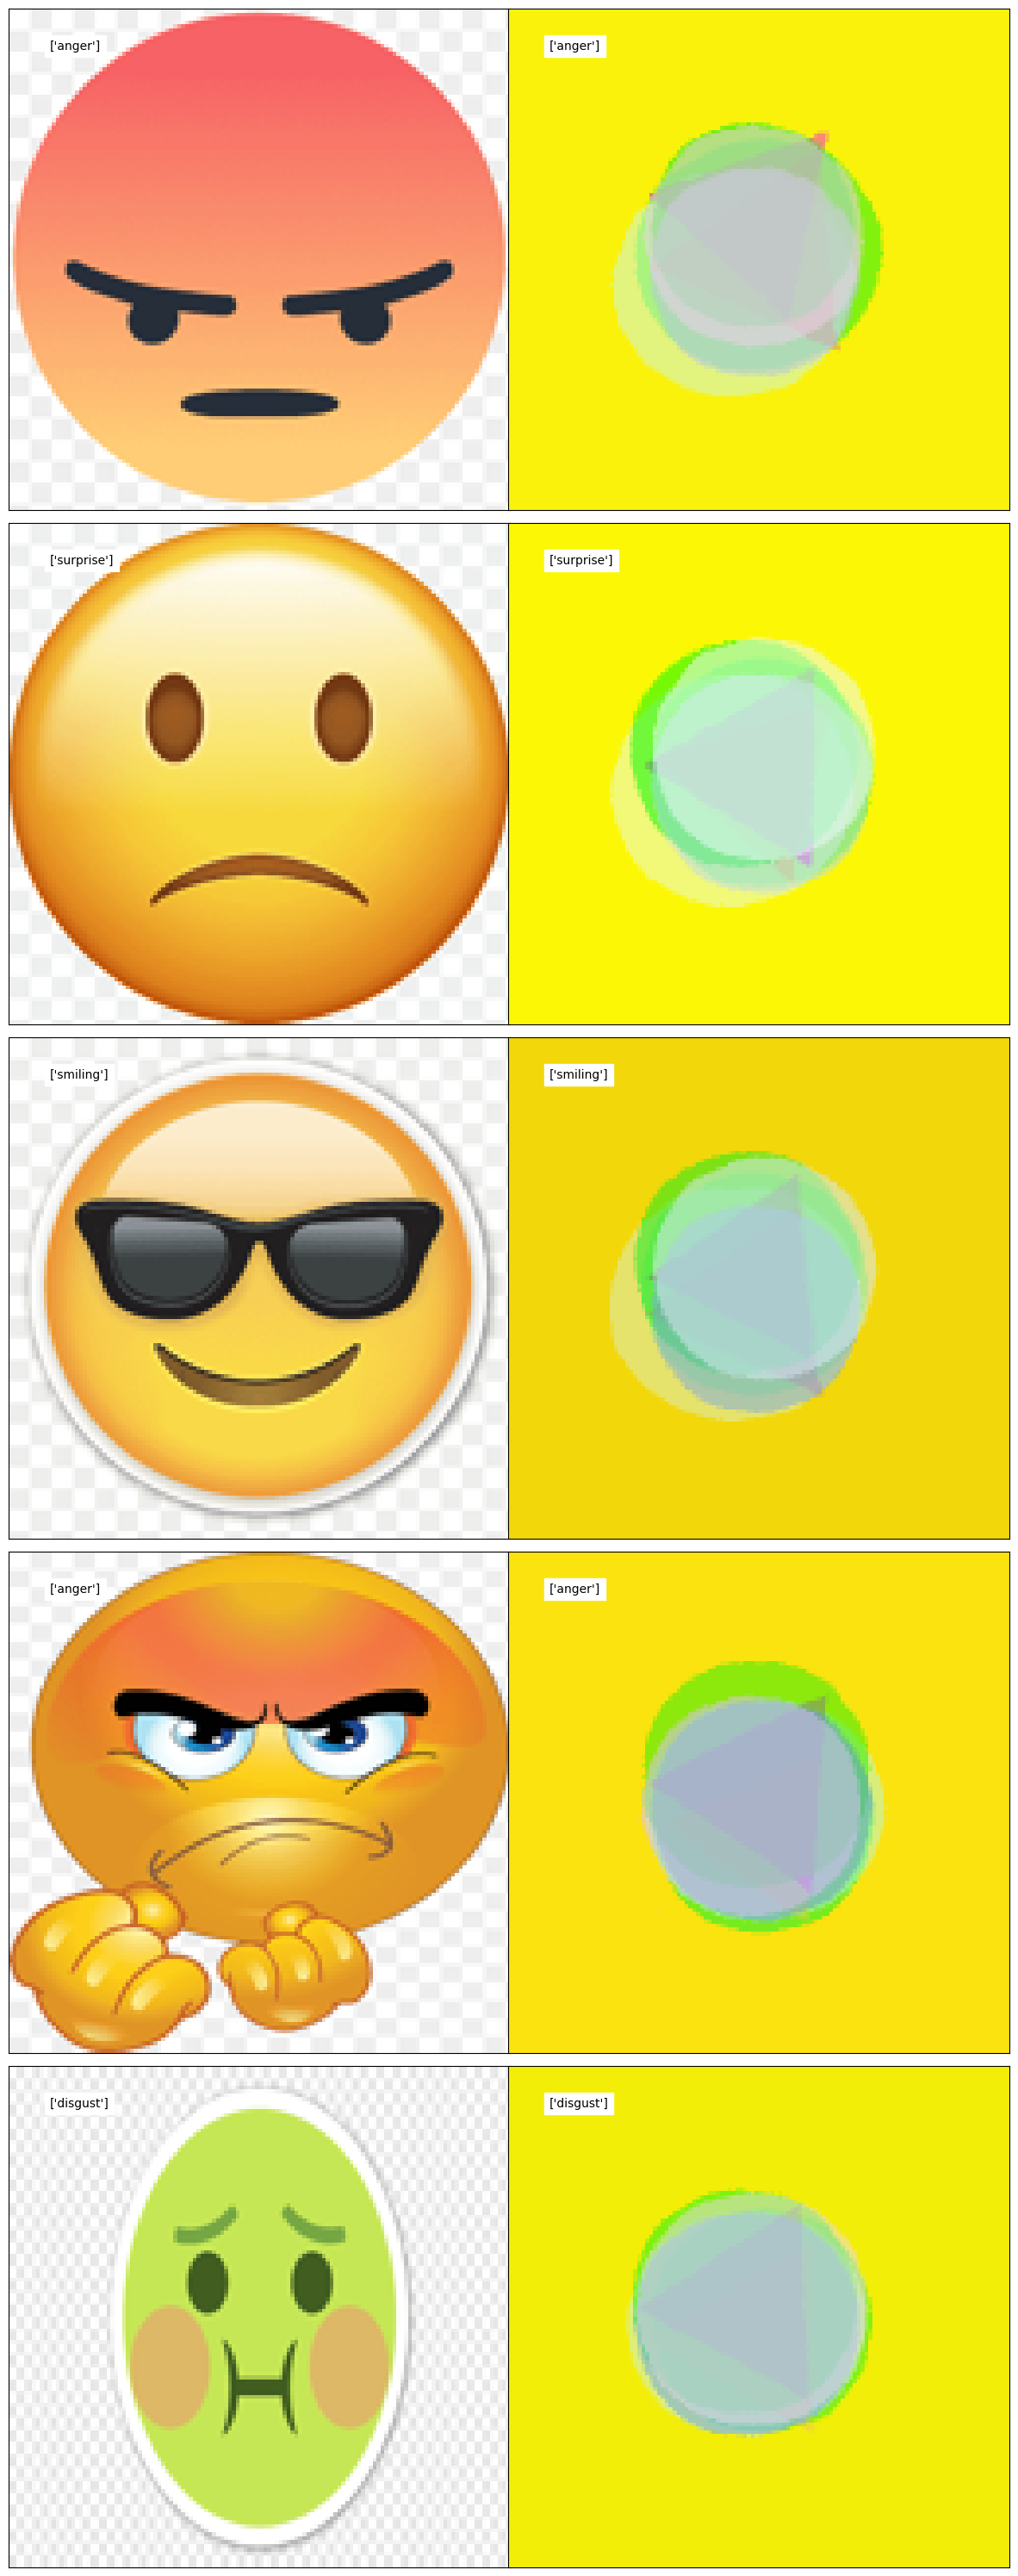

/home/dmitriy/OVE/covergan/weights/cgan_out.pt saved
 79%|███████▉  | 15/19 [00:11<00:03,  1.32it/s]


KeyboardInterrupt: 

In [51]:
from IPython.display import clear_output
from tqdm import tqdm
palette_generator = colorer
def generate(z, audio_embedding_disc):
    if palette_generator is None:
        return gen(z, audio_embedding_disc)
    return gen(z, audio_embedding_disc, palette_generator=palette_generator)

logger.info(f'PyDiffVG uses GPU: {pydiffvg.get_use_gpu()}')
# logger.info(gen)
# logger.info(disc)

n_epochs = 1000
disc_repeats = 5#Discriminator runs per iteration


disc_lr = gen_lr = 0.0003

z_dim = 32
disc_slices = 1
checkpoint_root = '/home/dmitriy/OVE/covergan/weights'
display_steps = 5
backup_epochs = 5
bin_steps = 20
plot_grad = False
c_lambda = 10
new_loss = torch.nn.BCELoss()
new_loss_log = torch.nn.BCEWithLogitsLoss()
batch_size=8
dataloader = DataLoader(dataset_image,drop_last=True, batch_size=batch_size, shuffle=True)

gen_opt = torch.optim.Adam(gen.parameters(), lr=gen_lr)
disc_opt = torch.optim.Adam(disc.parameters(), lr=disc_lr)
cgan_out_name='cgan_out'
print("Trying to load checkpoint.")
epochs_done = load_checkpoint(checkpoint_root, cgan_out_name, [gen, disc, gen_opt, disc_opt])
if epochs_done:
    logger.info(f"Loaded a checkpoint with {epochs_done} epochs done")

cur_step = 0
generator_losses = []
discriminator_losses = []
shuffle_losses = []
val_metrics = []

disc_repeat_cnt = 0
mean_iteration_disc_loss, mean_shuffle_disc_loss = 0, 0
for epoch in range(epochs_done + 1, n_epochs + epochs_done + 1):
    for emotion, image in tqdm(dataloader):
        torch.cuda.empty_cache()
        emotion = emotion.float().to(device)
        image = image.to(device)
        cur_batch_size = len(emotion)

        z = get_noise(cur_batch_size, z_dim, device=device)
        fake_labels = emotion
        # fake_labels = torch.nn.functional.one_hot(torch.randint(0, 7, (cur_batch_size,)), 7)
        fake_covers = generate(z, fake_labels)

        true_labels = torch.ones(batch_size).to(device).unsqueeze(-1)

        disc_opt.zero_grad()
        disc_real_pred = disc(image.permute(0, 3, 1, 2), emotion)


        real_disc_loss = new_loss(disc_real_pred, true_labels)

        fake_disc_pred = disc(fake_covers.detach(), fake_labels)

        gen_disc_loss = new_loss(fake_disc_pred, torch.zeros(batch_size).unsqueeze(-1).to(device))

        disc_loss = (real_disc_loss + gen_disc_loss) / 2
        # disc_loss.backward()
        disc_opt.step()

        discriminator_losses.append(disc_loss.item())

        gen_opt.zero_grad()
        fake_covers = generate(z, fake_labels)

        fake_disc_pred_gen = disc(fake_covers, fake_labels)
        gen_loss = new_loss(fake_disc_pred_gen, true_labels)

        # gen_loss.backward()
        gen_opt.step()

        generator_losses.append(gen_loss.item())

        if cur_step % display_steps == 0:
            plot_losses(epoch, cur_step, display_steps, bin_steps, [
                ("Generator", generator_losses),
                ("Discriminator Adversarial", discriminator_losses),
                ("Discriminator Mismatches", shuffle_losses)
            ])

            plot_real_fake_covers(fake_labels, image.permute(0, 3, 1, 2), fake_covers, disc_real_pred, fake_disc_pred, epoch=epoch,
                                    cur_step=cur_step)
            save_checkpoint(checkpoint_root, cgan_out_name, epoch, 0, [gen, disc, gen_opt, disc_opt])
        
        cur_step += 1


        # ### Update discriminator with fakes ###
        # Zero out the discriminator gradients

        # if disc_repeat_cnt == disc_repeats:

        # Make sure that enough predictions were made
        # Shapes must match

        # gp = get_gradient_penalty(disc, image.permute(0,3,1,2).data, fake_cover_tensor.data,
        #                           emotion)

                    # + c_lambda*gp
        # disc_loss = disc_fake_pred.mean() - disc_real_pred.mean() + c_lambda*gp
        # Keep track of the average critic loss in this batch
        # Update gradients
        # disc_loss.backward()
        # if plot_grad:
        #     plot_grad_flow(disc.named_parameters(), "discriminator (fakes)", epoch=epoch, cur_step=cur_step)
        # Update optimizer
        
        
        
        ###
        # shuffle_cover_tensor = mismatching_permute(image.permute(0,3,1,2))###
        #
        # if True:
        #     # ### Update discriminator with matching and shuffled cover-embedding pairs ###
        #     disc_opt.zero_grad()
        #
        #     disc_real_pred = disc(image.permute(0,3,1,2), emotion)
        #     disc_shuffle_pred = disc(shuffle_cover_tensor, emotion)
        #     # disc_loss = disc_shuffle_pred.mean() - disc_real_pred.mean()
        #     disc_loss = new_loss(disc_shuffle_pred,torch.zeros_like(disc_shuffle_pred))+new_loss(disc_real_pred,torch.ones_like(disc_real_pred))
        #     mean_shuffle_disc_loss += disc_loss.item() / disc_repeats
        #
        #     # Update gradients
        #     # disc_loss.backward()
        #     if plot_grad:
        #         plot_grad_flow(disc.named_parameters(), "discriminator (shuffled pairs)", epoch=epoch,
        #                        cur_step=cur_step)
        #     disc_opt.step()

            # Keep track of the average discriminator loss
        # discriminator_losses.append(mean_iteration_disc_loss)
        # shuffle_losses.append(mean_shuffle_disc_loss)
        # disc_repeat_cnt += 1
        # mean_iteration_disc_loss, mean_shuffle_disc_loss = 0, 0

        # ### Update generator ###
        # Zero out the generator gradients
        # gen_opt.zero_grad()

        # # Getting fake shapes, same as in the loop above
        # fake_cover_tensor, disc_fake_pred, fig_params = get_fake_pred(should_detach=False)

        # p_dist = torch.nn.PairwiseDistance()
        # dist_loss_sum = torch.tensor(0.0).to(fake_cover_tensor.device)
        # for figs in fig_params:
        #     cur_batch_dist_loss = torch.tensor(0.0).to(fake_cover_tensor.device)
        #     for ind_x, x in enumerate(figs):
        #         for ind_y in range(ind_x + 1, len(figs)):
        #             a = x["center_point"]
        #             b = figs[ind_y]["center_point"]
        #             cur_batch_dist_loss += 50000 / (p_dist(a, b)) ** 3
        #     dist_loss_sum += cur_batch_dist_loss / len(figs)
        #
        # dist_loss_sum = dist_loss_sum / len(fig_params)
        # dist_loss_sum.backward()
        # gen_loss = -disc_fake_pred.mean() + dist_loss_sum
        # gen_loss = -disc_fake_pred.mean()

        # gen_loss = new_loss(disc_fake_pred,torch.ones_like(disc_fake_pred))
        # # gen_loss.backward()
        # # gen_loss.backward()
        # if plot_grad:
        #     plot_grad_flow(gen.named_parameters(), "generator", epoch=epoch, cur_step=cur_step)

        # Update the weights
        # gen_opt.step()

        # # Keep track of the generator losses
        # generator_losses.append(gen_loss.item())
        # # clear_output()


In [ ]:
z = get_noise(2, z_dim, device=device)

In [54]:
dataloader2 = DataLoader(dataset_image,drop_last=True, batch_size=2, shuffle=True)

In [ ]:
z

In [ ]:
a = next(iter(dataloader2))[0]

In [ ]:
gen.train(False)

In [ ]:
b = gen(z, a, palette_generator=palette_generator,return_diffvg_svg_params=True)[0]

In [ ]:
b[0]

In [ ]:
for ind, params in enumerate(b):
    pydiffvg.save_svg(f'/home/dmitriy/OVE/plots/back_diffvg_svg_{ind}.svg', *params)

In [ ]:
# from service_utils import add_filter
# from service_utils import OverlayFilter
# num_samples = 2
# # filtered_samples = round(num_samples // 2)
# filtered_samples = num_samples
# filters = list(OverlayFilter)
# for psvg_cover in b[-filtered_samples:]:
#     overlay_filter = random.choice(filters)
#     add_filter(psvg_cover, overlay_filter)